# Embedding projection of the different classes on the ZS datasets

In [1]:
from os.path import join 
import torchvision.transforms as transforms
import torch 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from lscaleuq.dataset_uq import CIFAR10Dataset, CIFAR100Dataset, FGVCAircraftDataset, Caltech101Dataset, StanfordCarsDataset, EuroSATDataset, Flowers102Dataset, Food101Dataset, OxfordPetsDataset, DTDDataset, SUN397Dataset, UCF101Dataset
from lscaleuq.dataset_uq.utils import ConvertImageToRGB
from lscaleuq.dataset_uq.templates import get_templates
from lscaleuq.models.clip import tokenize as clip_tokenize
from lscaleuq.models.clip import load as load_clip

## Load ZS datasets

In [2]:
cluster_env_path = "/share/DEEPLEARNING/datasets/LargeScaleUQ" 
transform_val = transforms.Compose([
    transforms.Resize(size=224, interpolation=3),
    transforms.CenterCrop(size=224),
    ConvertImageToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

datasets = {
    "CIFAR10": CIFAR10Dataset(
        root=join(cluster_env_path, "CIFAR-10"),
        train=False,
        transform=transform_val,
    ),
    "CIFAR100": CIFAR100Dataset(
        root=join(cluster_env_path, "CIFAR-100"),
        train=False,
        transform=transform_val,
    ),
    "Aircraft": FGVCAircraftDataset(
        root=join(cluster_env_path, "dataset_suite"),
        split="test",
        transform=transform_val,
    ),
    "Caltech101": Caltech101Dataset(
        root=join(cluster_env_path, "dataset_suite", "caltech101"),
        split="test",
        transform=transform_val,
    ),
    "Cars": StanfordCarsDataset(
        root=join(cluster_env_path, "dataset_suite", "stanford_cars"),
        split="test",
        transform=transform_val,
    ),
    "EuroSAT": EuroSATDataset(
        root=join(cluster_env_path, "dataset_suite", "EuroSAT_RGB"),
        split="test",
        transform=transform_val,
    ),
    "Flowers": Flowers102Dataset(
        root=join(cluster_env_path, "dataset_suite", "flowers102"),
        split="test",
        transform=transform_val,
    ),
    "Food": Food101Dataset(
        root=join(cluster_env_path, "dataset_suite", "food-101"),
        split="test",
        transform=transform_val,
    ),
    "Pets": OxfordPetsDataset(
        root=join(cluster_env_path, "dataset_suite", "oxford-iiit-pet"),
        split="test",
        transform=transform_val,
    ),
    "Textures": DTDDataset(
        root=join(cluster_env_path, "dataset_suite", "dtddataset"),
        split="test",
        transform=transform_val,
    ),
    "SUN": SUN397Dataset(
        root=join(cluster_env_path, "dataset_suite", "SUN397"),
        split="test",
        transform=transform_val,
    ),
    "UCF": UCF101Dataset(
        root=join(cluster_env_path, "dataset_suite", "UCF-101-midframes"),
        split="test",
        transform=transform_val,
    ),
}

In [3]:
datasets["CIFAR10"].class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Load CLIP 

In [15]:
device = "cuda:0"
name = "ViT-B/16"
vision_dim = 512
textual_dim = 512
logit_scale = None

clip_model, _ = load_clip(name=name)
clip_model = clip_model.to(device)

## Encode class names

In [16]:
template = get_templates('base')
class_names = datasets["CIFAR10"].class_names
[template[0].format(name) for name in class_names]



['a photo of a airplane.',
 'a photo of a automobile.',
 'a photo of a bird.',
 'a photo of a cat.',
 'a photo of a deer.',
 'a photo of a dog.',
 'a photo of a frog.',
 'a photo of a horse.',
 'a photo of a ship.',
 'a photo of a truck.']

In [17]:
class_names = clip_tokenize([template[0].format(name) for name in class_names])
with torch.no_grad():
    text_feats = clip_model.encode_text(class_names.to(device))
    text_feats /= text_feats.norm(dim=-1, keepdim=True)

In [18]:
text_feats.shape

torch.Size([10, 512])

## ACP of class features 

In [19]:
def plot_pca(dataset_name):
    template = get_templates('base')
    class_names = datasets[dataset_name].class_names
    n_classes = len(class_names)
    class_names = clip_tokenize([template[0].format(name) for name in class_names])
    with torch.no_grad():
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)
        
    data = text_feats.cpu().numpy()
    # ACP
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Visualisation
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=range(n_classes), cmap="tab10", s=100)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"PCA of classes name for {dataset_name}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

In [20]:
def plot_tsne(dataset_name):
    template = get_templates('base')
    class_names = datasets[dataset_name].class_names
    n_classes = len(class_names)
    class_names = clip_tokenize([template[0].format(name) for name in class_names])
    with torch.no_grad():
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)

    data = text_feats.cpu().numpy()
    # t-SNE
    perplexity = n_classes // 3
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=3000)
    reduced_data = tsne.fit_transform(data)

    # Visualisation
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=range(n_classes), cmap="tab10", s=100)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"t-SNE of classes name for {dataset_name}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

In [ ]:
for dataset_name in datasets.keys():
    plot_pca(dataset_name)

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


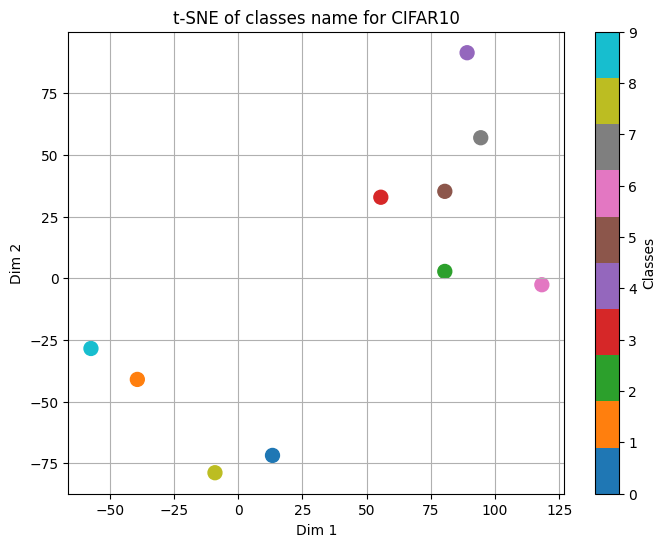

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


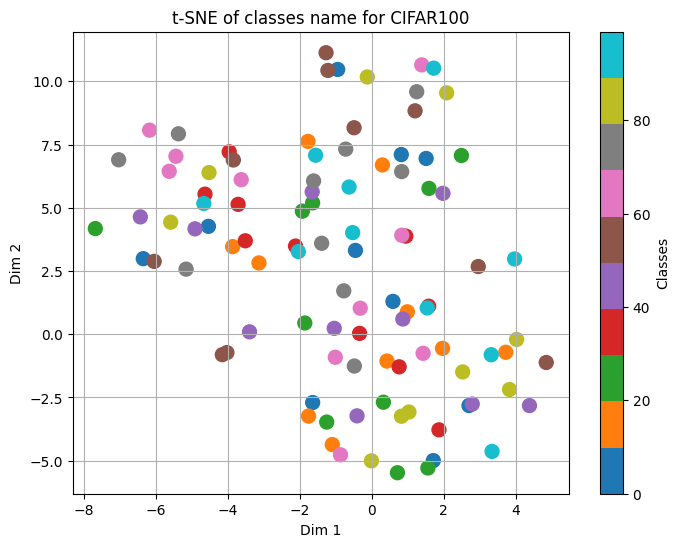

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


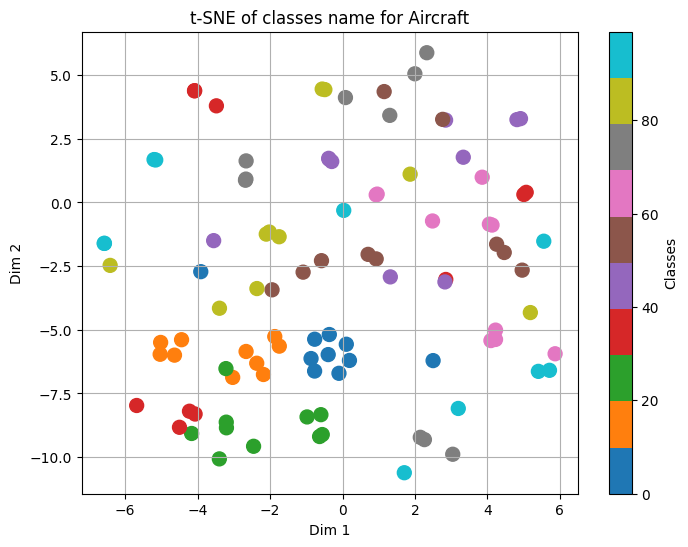

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


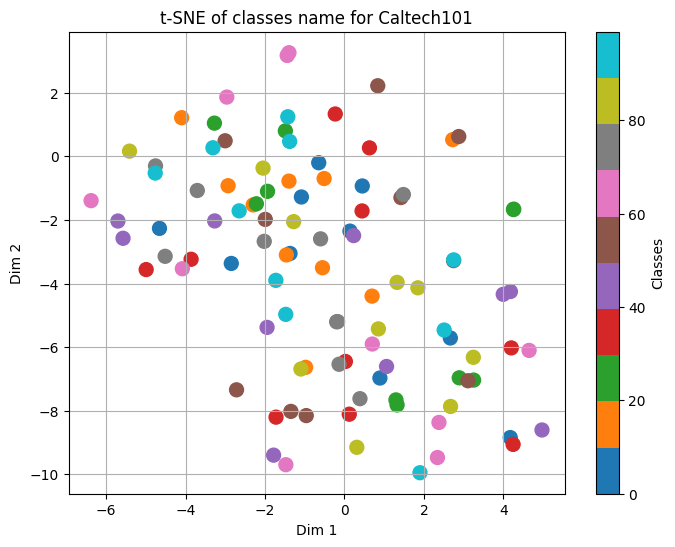

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


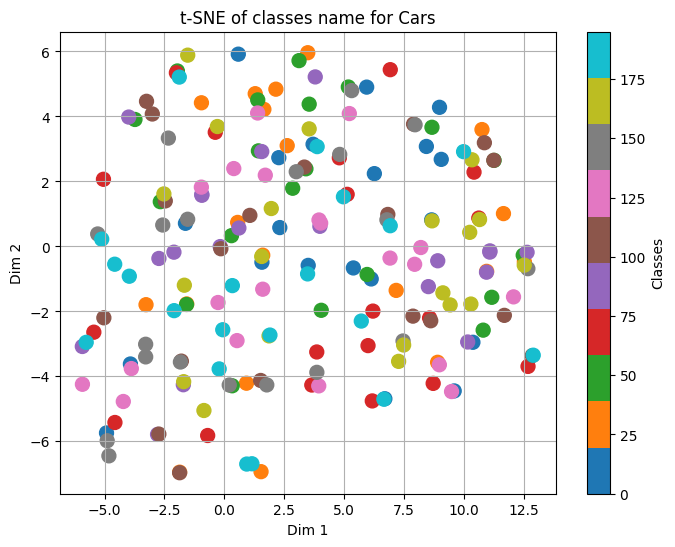

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


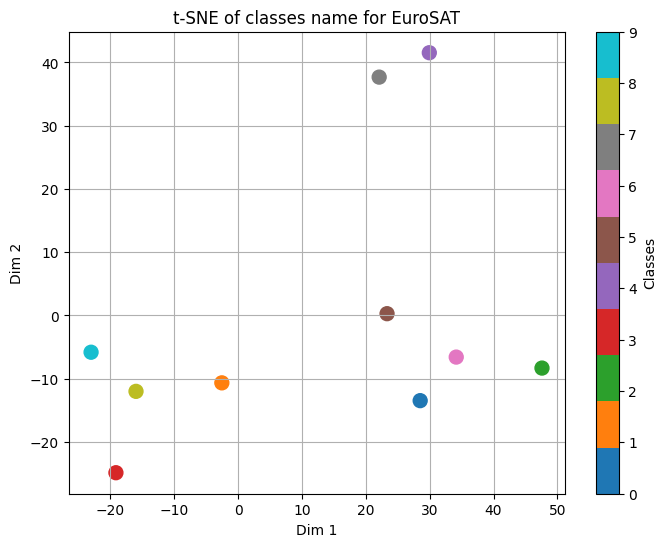

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


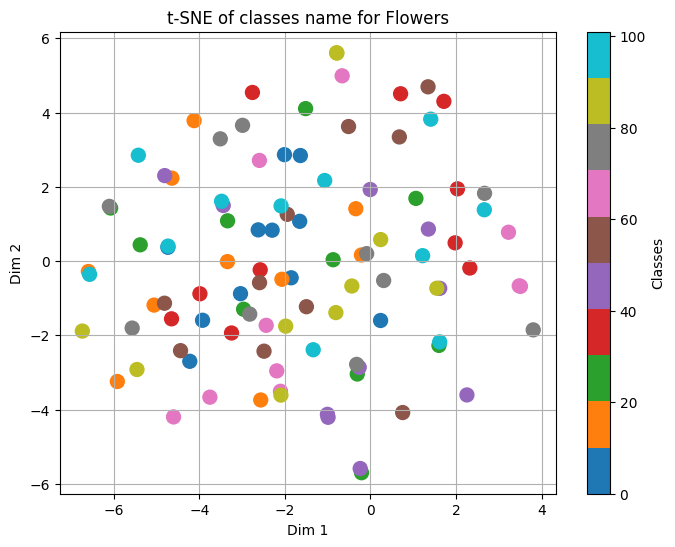

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


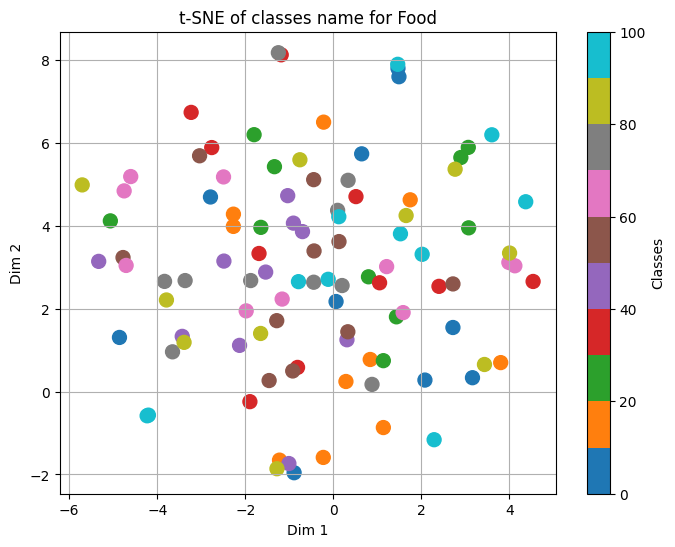

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


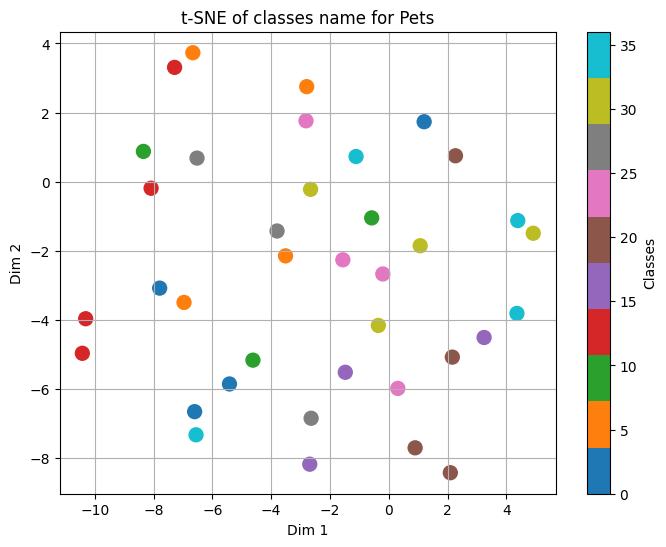

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


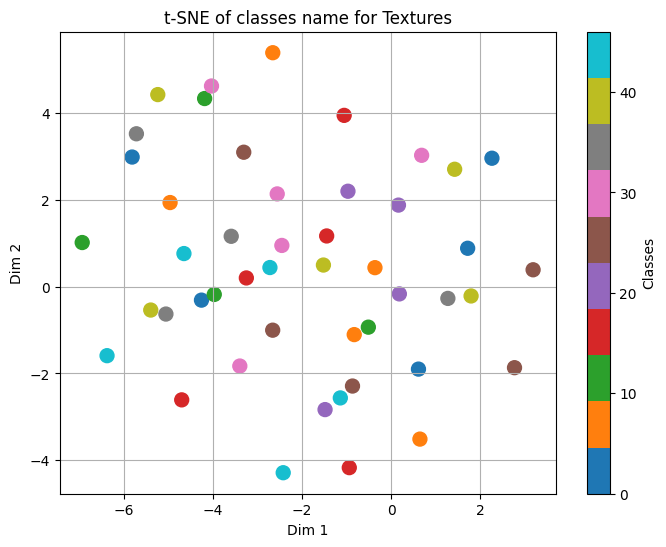

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


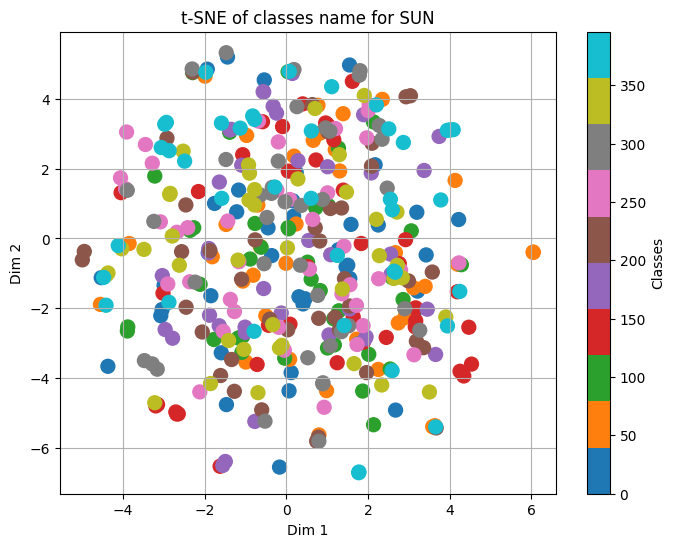

/users/k/karmimy/anaconda3/envs/lscaleuq/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


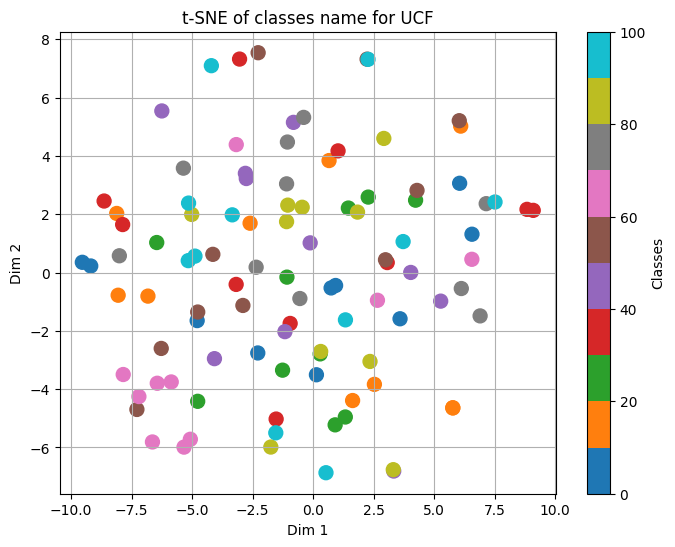

In [21]:
for dataset_name in datasets.keys():
    plot_tsne(dataset_name)